# Training U-Net model
## 250 Epochs, No Dropout, Adam Optimizer, Learning Rate 1e-3

In [1]:
import sys
sys.path.append("..")
import os, re, glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from src import data,unet_dilation

Using TensorFlow backend.


In [2]:
from keras import utils
train_dir = "/home/ubuntu/TrainingSet"
weight_file = 'saved_models/endo_models/weights-500Epochs-NoDrop-Adam3-Dilation.hdf5'
epi_weight_file = 'saved_models/epi_models/weights-500Epochs-NoDrop-Adam3-Dilation.hdf5'
save_imgs_dir = 'images/train500NoDrpAdam3Dilation/endo_images'
save_imgs_dir_epi = 'images/train500NoDrpAdam3Dilation/epi_images'

images = []
inner_masks = []
outer_masks = []

patient_directories = sorted(glob.glob(os.path.join(train_dir, "patient*")))

for patient_dir in patient_directories:
    imgdata = data.ImageData(patient_dir)
    images += imgdata.labeled_images
    inner_masks += imgdata.endo_masks
    outer_masks += imgdata.epi_masks

images = np.asarray(images)[:,:,:,None].astype('float64')
i_masks = np.asarray(inner_masks)
o_masks = np.asarray(outer_masks)

dims = i_masks.shape
classes = len(set(i_masks[0].flatten()))
new_shape = dims + (classes,)
i_masks = utils.to_categorical(i_masks).reshape(new_shape)
o_masks = utils.to_categorical(o_masks).reshape(new_shape)

#i_masks_cropped=[]
#crop_x = 8

#for mask in i_masks:
#    i_masks_cropped.append(mask[0+crop_x//2:216-crop_x//2,:,:])

#print(i_masks[0].shape)
#print(i_masks_cropped[0].shape)

#i_masks_final = np.asarray(i_masks_cropped)



def normalize(x, epsilon=1e-7, axis=(1,2)):
    x -= np.mean(x, axis=axis, keepdims=True)
    x /= np.std(x, axis=axis, keepdims=True) + epsilon
    
normalize(images,axis=(1,2))

print("There are %d total training images." % len(images))
print("There are %d total inner masks." % len(inner_masks))
print("There are %d total outer masks." % len(outer_masks))

There are 243 total training images.
There are 243 total inner masks.
There are 243 total outer masks.


In [3]:
height,width,_ = images[0].shape
dropout = 0.0
unet_conv = unet_dilation.UNet()

model = unet_conv.get_unet(height=height, width=width, channels=1,features=32,steps=3,dropout=dropout,padding='same')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 216, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 216, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 216, 256, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 216, 256, 32) 0           activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

In [4]:
from keras.optimizers import Adam, SGD
from keras import backend as K

def dice_coef(y_true, y_pred):
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    intersection = K.sum(flat_y_true * flat_y_pred)
    return (2. * intersection + 1.) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + 1.)

def dice_coef_np(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + 1.) / (np.sum(y_true) + np.sum(y_pred) + 1.)


def pixelwise_crossentropy(y_true, y_pred, weights=[0.5,0.5], epsilon=1e-8):
    ndim = K.ndim(y_pred)
    ncategory = K.int_shape(y_pred)[-1]
    # scale predictions so class probabilities of each pixel sum to 1
    y_pred /= K.sum(y_pred, axis=(ndim-1), keepdims=True)
    y_pred = K.clip(y_pred, epsilon, 1-epsilon)
    w = K.constant(weights) * (ncategory / sum(weights))
    # first, average over all axis except classes
    cross_entropies = -K.mean(y_true * K.log(y_pred), axis=tuple(range(ndim-1)))
    return K.sum(w * cross_entropies)

In [5]:
model.compile(optimizer=Adam(lr=1e-2),loss=[pixelwise_crossentropy],metrics=[dice_coef])

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from math import ceil

seed = 78

validation_split = 0.2

epochs = 500
batch_size = 32


split_index = int((1 - validation_split) * len(images))

train_steps = ceil(split_index / batch_size)
val_steps = ceil((len(images)-split_index )/batch_size)

train_images = images[:split_index]
train_inner_masks = i_masks[:split_index]
train_outer_masks = o_masks[:split_index]

validation_images = images[split_index:]
validation_inner_masks = i_masks[split_index:]
validation_outer_masks = o_masks[split_index:]


data_gen_args = dict(rotation_range=180,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.01,
                     fill_mode='nearest')

train_images_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**data_gen_args)


#seed = 1
#height,width,channels = train_images[0].shape
#print(train_images[0].shape)
#print(train_inner_masks[0].shape)
train_images_datagen.fit(train_images,augment=True,seed=seed)
train_masks_datagen.fit(train_inner_masks,augment=True,seed=seed)

train_images_generator = train_images_datagen.flow(train_images, y=None, seed=seed)
train_masks_generator = train_images_datagen.flow(train_inner_masks, y=None, seed=seed)


train_generator = zip(train_images_generator, train_masks_generator)

/usr/local/lib/python3.5/dist-packages/Keras-2.1.3-py3.5.egg/keras/preprocessing/image.py:722: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
/usr/local/lib/python3.5/dist-packages/Keras-2.1.3-py3.5.egg/keras/preprocessing/image.py:896: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).


In [ ]:
checkpointer = ModelCheckpoint(filepath=weight_file, verbose=1, save_best_only=True)

hist = model.fit_generator(train_generator,steps_per_epoch=train_steps,epochs=epochs,verbose=1,callbacks=[checkpointer],
                   validation_data=(validation_images,validation_inner_masks),validation_steps=val_steps)

Epoch 1/500
6/7 [========================>.....] - ETA: 3s - loss: 0.7600 - dice_coef: 0.7876
Epoch 00001: val_loss improved from inf to 0.74970, saving model to saved_models/endo_models/weights-500Epochs-NoDrop-Adam3-Dilation.hdf5
7/7 [==============================] - 23s 3s/step - loss: 0.6934 - dice_coef: 0.8129 - val_loss: 0.7497 - val_dice_coef: 0.9593
Epoch 2/500
6/7 [========================>.....] - ETA: 1s - loss: 0.9527 - dice_coef: 0.9483
Epoch 00002: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.9765 - dice_coef: 0.9470 - val_loss: 0.7497 - val_dice_coef: 0.9593
Epoch 3/500
6/7 [========================>.....] - ETA: 1s - loss: 0.9473 - dice_coef: 0.9486
Epoch 00003: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 1.0436 - dice_coef: 0.9433 - val_loss: 0.7497 - val_dice_coef: 0.9593
Epoch 4/500
6/7 [========================>.....] - ETA: 1s - loss: 0.9519 - dice_coef: 0.9483
Epoch 00004: val_loss did

6/7 [========================>.....] - ETA: 1s - loss: 0.9632 - dice_coef: 0.9477
Epoch 00032: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.8608 - dice_coef: 0.9533 - val_loss: 0.7497 - val_dice_coef: 0.9593
Epoch 33/500
6/7 [========================>.....] - ETA: 1s - loss: 0.9614 - dice_coef: 0.9478
Epoch 00033: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.8992 - dice_coef: 0.9512 - val_loss: 0.7497 - val_dice_coef: 0.9593
Epoch 34/500
6/7 [========================>.....] - ETA: 1s - loss: 0.9573 - dice_coef: 0.9480
Epoch 00034: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.9306 - dice_coef: 0.9495 - val_loss: 0.7497 - val_dice_coef: 0.9593
Epoch 35/500
6/7 [========================>.....] - ETA: 1s - loss: 0.9488 - dice_coef: 0.9485
Epoch 00035: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 1.0350 - dice_coef: 0.9438 - val_loss: 

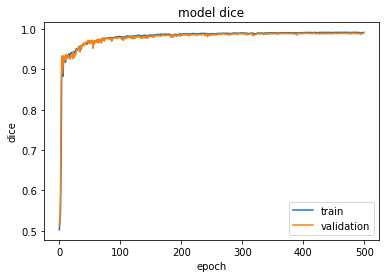

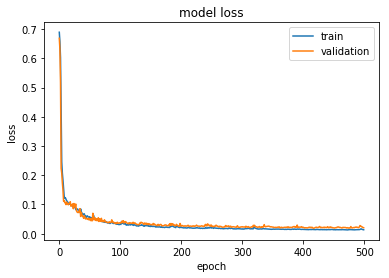

In [9]:
def show_plots(history):
    fig = plt.figure()
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice')
    plt.ylabel('dice')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    fig.savefig(os.path.join(save_imgs_dir,"dice-plot.png"))
    
    fig2 = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    fig2.savefig(os.path.join(save_imgs_dir,"loss-plot.png"))
show_plots(hist)

In [10]:
import tensorflow as tf

model.load_weights(weight_file)

def calculate_dice(images, masks_true):
    dices = []
    masks_pred = np.concatenate([model.predict(image[None,:,:,:]) for image in images])
    for mask_true, mask_pred in zip(masks_true, masks_pred):
        y_true = mask_true[:,:,1].astype('uint8')
        y_pred = np.round(mask_pred[:,:,1]).astype('uint8')
        dices.append(dice_coef_np(y_true.flatten(), y_pred.flatten()))
    print("Dice Average: {:.2f} Dice Stdev: {:.2f}".format(np.mean(dices), np.std(dices)))

In [11]:
print("Training Statistics(No Dropout)...")
calculate_dice(train_images, train_inner_masks)
print("Validation Statistics(No Dropout)...")
calculate_dice(validation_images, validation_inner_masks)

Training Statistics(No Dropout)...
Dice Average: 0.89 Dice Stdev: 0.12
Validation Statistics(No Dropout)...
Dice Average: 0.79 Dice Stdev: 0.25


# View Predictions on Validation Set

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


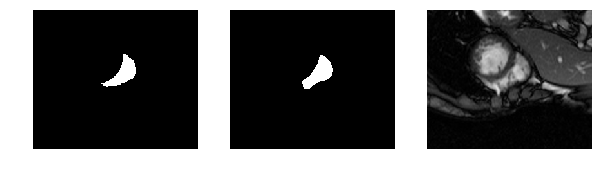

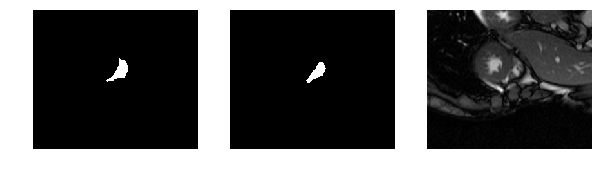

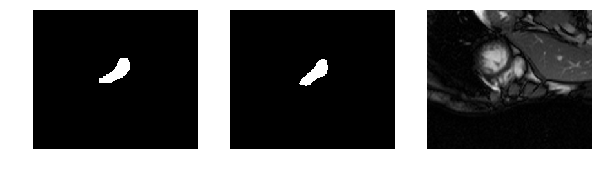

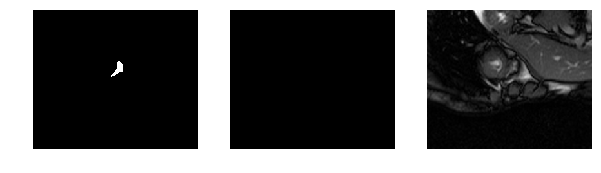

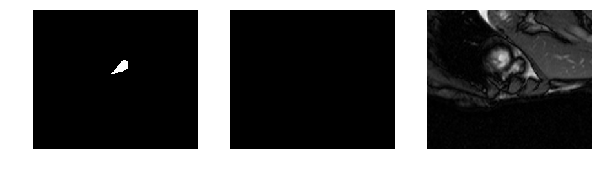

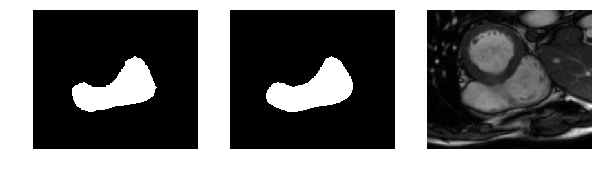

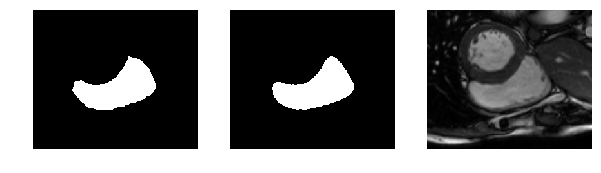

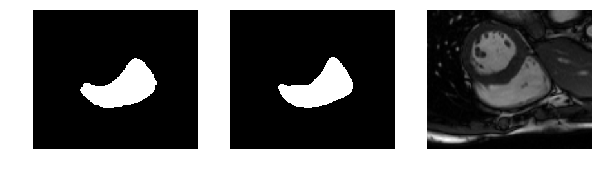

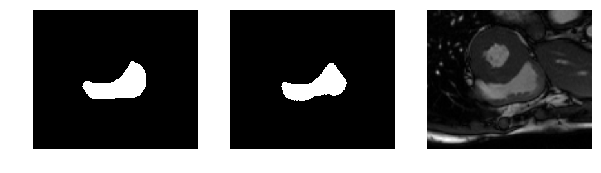

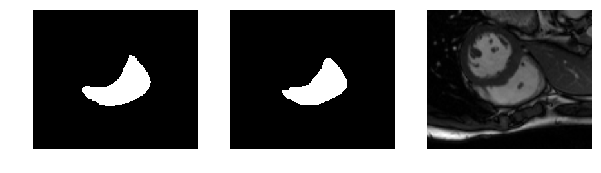

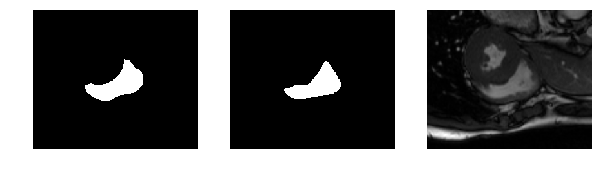

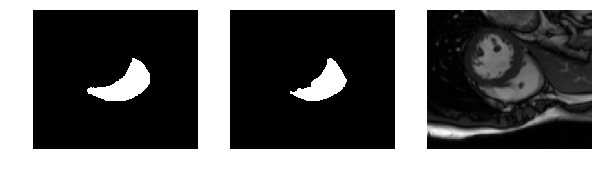

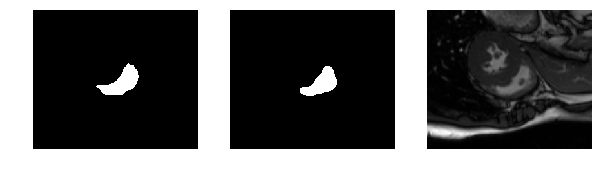

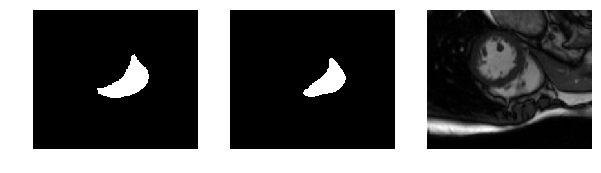

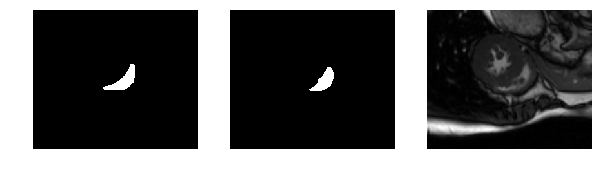

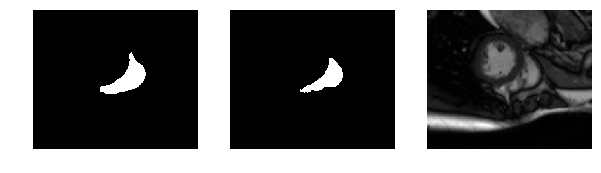

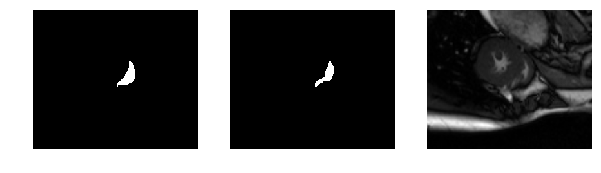

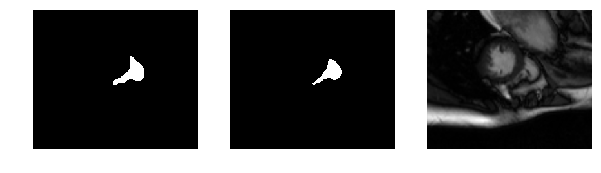

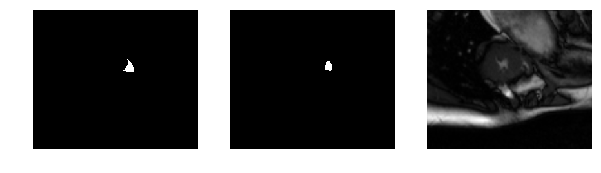

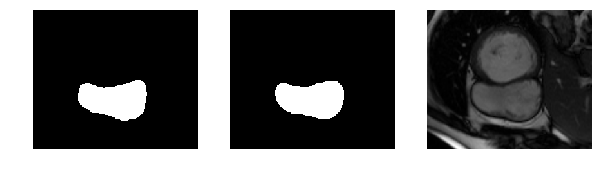

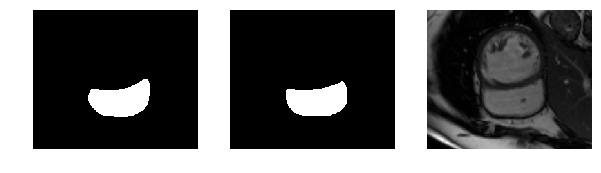

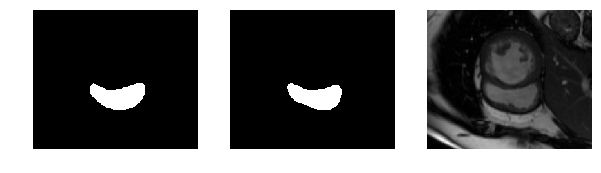

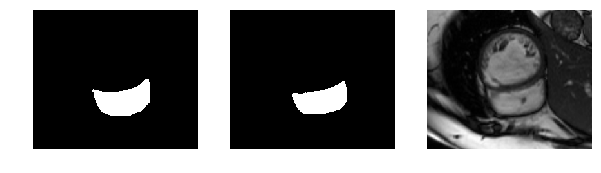

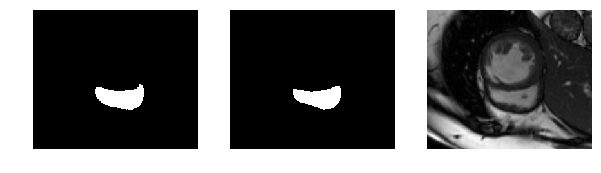

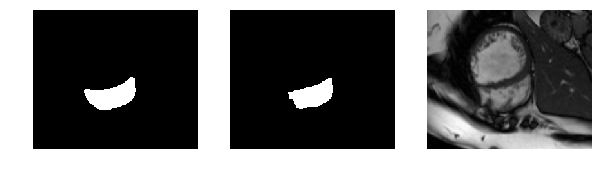

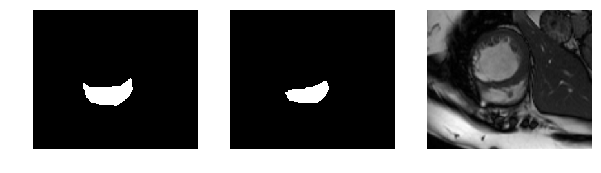

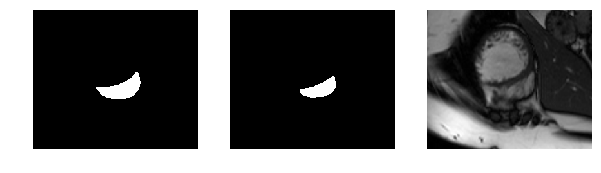

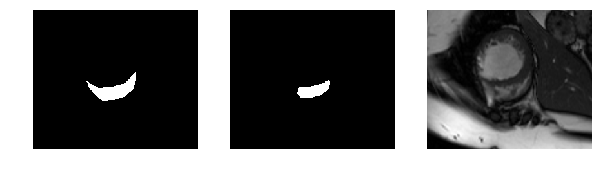

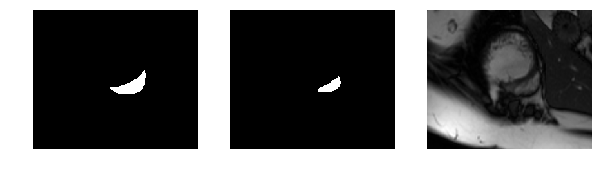

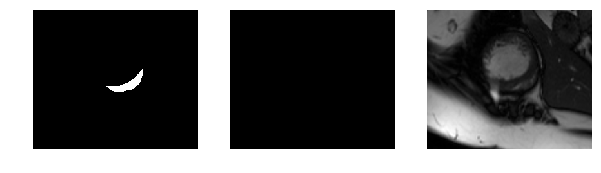

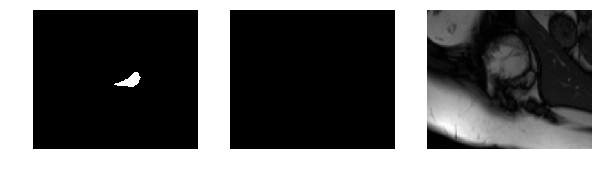

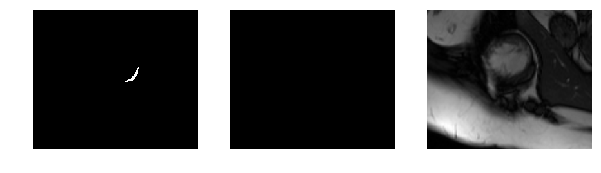

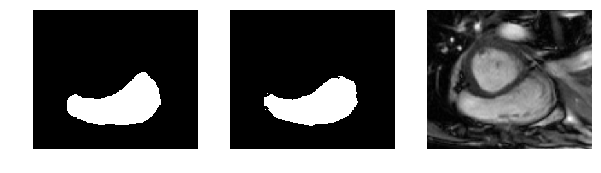

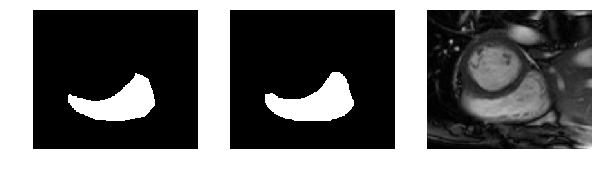

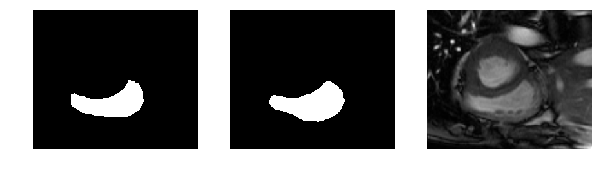

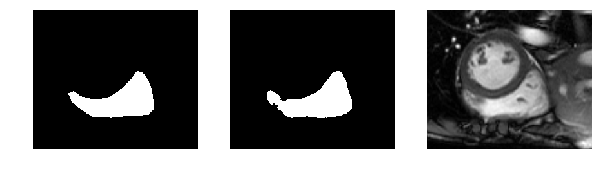

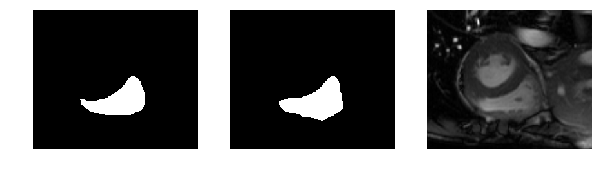

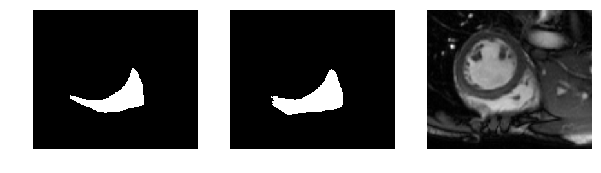

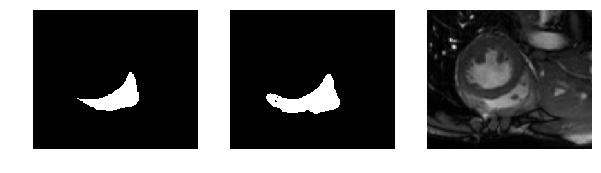

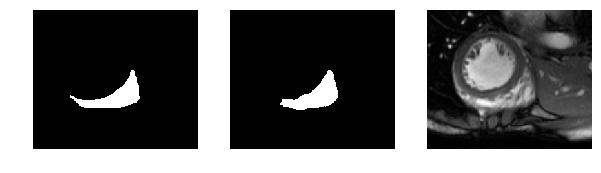

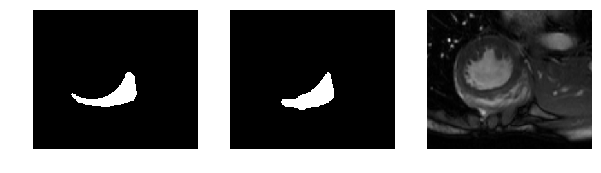

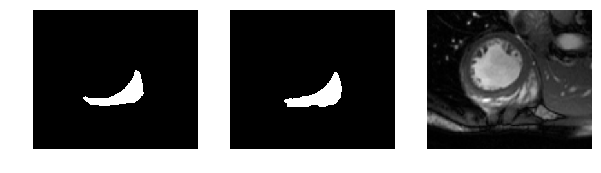

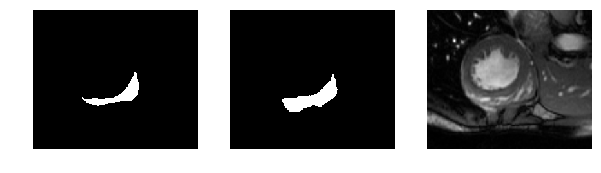

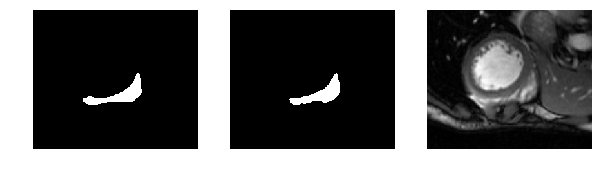

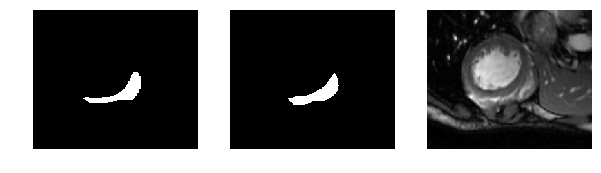

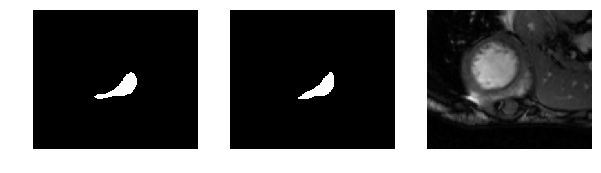

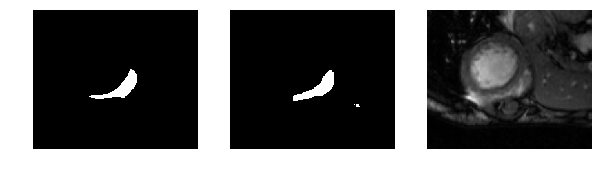

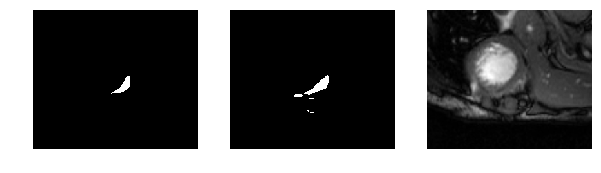

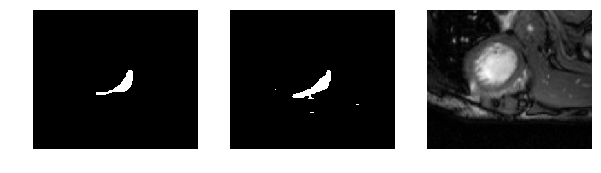

In [11]:
def show_masks(images, i_masks_true):
    masks_pred = np.concatenate([model.predict(image[None,:,:,:]) for image in images])
    counter = 0
    for (image,i_mask,mask_pred) in zip(images,i_masks_true,masks_pred):
        plt.figure(figsize=(10,5))
        plt.subplot(1, 3, 1)
        plt.axis("off")
        plt.imshow(i_mask, cmap=plt.cm.gray)
        plt.subplot(1,3,2)
        plt.axis("off")
        plt.imshow(np.where(mask_pred[:,:,1]>0.5,255,0),cmap=plt.cm.gray)
        plt.subplot(1, 3, 3)
        plt.axis("off")
        plt.imshow(image[:,:,0], cmap=plt.cm.gray)
        counter += 1
        filename = "{:2d}.png".format(counter)
        plt.savefig(os.path.join(save_imgs_dir, filename))
        
show_masks(images[split_index:], inner_masks[split_index:])

# Train on Epicadrium

In [13]:
height,width,_ = images[0].shape
dropout=0.0

unet_conv_epi = unet_dilation.UNet()

model_epi = unet_conv_epi.get_unet(height=height, width=width, channels=1,features=32,steps=3,dropout=dropout,padding='same')
model_epi.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 216, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 216, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 216, 256, 32) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 216, 256, 32) 0           activation_19[0][0]              
__________________________________________________________________________________________________
conv2d_20 

In [15]:
model_epi.compile(optimizer=Adam(lr=1e-3),loss=[pixelwise_crossentropy],metrics=[dice_coef])

In [18]:
train_images_datagen.fit(train_images,augment=True,seed=seed)
train_masks_datagen.fit(train_outer_masks,augment=True,seed=seed)

train_images_generator = train_images_datagen.flow(train_images, y=None, seed=seed)
train_masks_generator = train_images_datagen.flow(train_outer_masks, y=None, seed=seed)


train_generator = zip(train_images_generator, train_masks_generator)

/usr/local/lib/python3.5/dist-packages/Keras-2.1.3-py3.5.egg/keras/preprocessing/image.py:722: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
/usr/local/lib/python3.5/dist-packages/Keras-2.1.3-py3.5.egg/keras/preprocessing/image.py:896: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).


In [19]:
checkpointer_epi = ModelCheckpoint(filepath=epi_weight_file, verbose=1, save_best_only=True)

hist_epi = model_epi.fit_generator(train_generator,steps_per_epoch=train_steps,epochs=epochs,verbose=1,callbacks=[checkpointer_epi],
                   validation_data=(validation_images,validation_outer_masks),validation_steps=val_steps)

Epoch 1/250
6/7 [========================>.....] - ETA: 1s - loss: 0.5583 - dice_coef: 0.6239
Epoch 00001: val_loss improved from inf to 0.27011, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3-Dilation.hdf5
7/7 [==============================] - 11s 2s/step - loss: 0.5068 - dice_coef: 0.6579 - val_loss: 0.2701 - val_dice_coef: 0.8945
Epoch 2/250
6/7 [========================>.....] - ETA: 1s - loss: 0.2440 - dice_coef: 0.8856
Epoch 00002: val_loss improved from 0.27011 to 0.23691, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3-Dilation.hdf5
7/7 [==============================] - 9s 1s/step - loss: 0.2402 - dice_coef: 0.8832 - val_loss: 0.2369 - val_dice_coef: 0.8273
Epoch 3/250
6/7 [========================>.....] - ETA: 1s - loss: 0.2420 - dice_coef: 0.8332
Epoch 00003: val_loss improved from 0.23691 to 0.18697, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3-Dilation.hdf5
7/7 [==============================] - 9s 

Epoch 28/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0813 - dice_coef: 0.9460
Epoch 00028: val_loss improved from 0.07717 to 0.07441, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3-Dilation.hdf5
7/7 [==============================] - 9s 1s/step - loss: 0.0771 - dice_coef: 0.9493 - val_loss: 0.0744 - val_dice_coef: 0.9646
Epoch 29/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0758 - dice_coef: 0.9579
Epoch 00029: val_loss improved from 0.07441 to 0.07067, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3-Dilation.hdf5
7/7 [==============================] - 9s 1s/step - loss: 0.0750 - dice_coef: 0.9576 - val_loss: 0.0707 - val_dice_coef: 0.9585
Epoch 30/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0768 - dice_coef: 0.9558
Epoch 00030: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0768 - dice_coef: 0.9553 - val_loss: 0.0855 - val_dice_coef: 0.9534
Epoch 31/25

6/7 [========================>.....] - ETA: 1s - loss: 0.0269 - dice_coef: 0.9840
Epoch 00085: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0279 - dice_coef: 0.9833 - val_loss: 0.0387 - val_dice_coef: 0.9771
Epoch 86/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0286 - dice_coef: 0.9831
Epoch 00086: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0328 - dice_coef: 0.9821 - val_loss: 0.0428 - val_dice_coef: 0.9766
Epoch 87/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0375 - dice_coef: 0.9778
Epoch 00087: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0379 - dice_coef: 0.9776 - val_loss: 0.0533 - val_dice_coef: 0.9700
Epoch 88/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0347 - dice_coef: 0.9795
Epoch 00088: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0339 - dice_coef: 0.9798 - val_loss: 

Epoch 116/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0250 - dice_coef: 0.9854
Epoch 00116: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0249 - dice_coef: 0.9854 - val_loss: 0.0306 - val_dice_coef: 0.9825
Epoch 117/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0237 - dice_coef: 0.9860
Epoch 00117: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0232 - dice_coef: 0.9861 - val_loss: 0.0323 - val_dice_coef: 0.9811
Epoch 118/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0234 - dice_coef: 0.9857
Epoch 00118: val_loss improved from 0.03037 to 0.03036, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3-Dilation.hdf5
7/7 [==============================] - 9s 1s/step - loss: 0.0241 - dice_coef: 0.9852 - val_loss: 0.0304 - val_dice_coef: 0.9825
Epoch 119/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0256 - dice_coef: 0.9846
Epoch 00119: va

Epoch 146/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0206 - dice_coef: 0.9875
Epoch 00146: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0199 - dice_coef: 0.9877 - val_loss: 0.0314 - val_dice_coef: 0.9834
Epoch 147/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0208 - dice_coef: 0.9876
Epoch 00147: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0213 - dice_coef: 0.9873 - val_loss: 0.0286 - val_dice_coef: 0.9836
Epoch 148/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0211 - dice_coef: 0.9871
Epoch 00148: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0208 - dice_coef: 0.9871 - val_loss: 0.0383 - val_dice_coef: 0.9797
Epoch 149/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0216 - dice_coef: 0.9870
Epoch 00149: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0210 - dice_coef: 0.

Epoch 177/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0177 - dice_coef: 0.9889
Epoch 00177: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0175 - dice_coef: 0.9889 - val_loss: 0.0311 - val_dice_coef: 0.9848
Epoch 178/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0174 - dice_coef: 0.9897
Epoch 00178: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0168 - dice_coef: 0.9899 - val_loss: 0.0287 - val_dice_coef: 0.9859
Epoch 179/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0170 - dice_coef: 0.9898
Epoch 00179: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0170 - dice_coef: 0.9897 - val_loss: 0.0266 - val_dice_coef: 0.9866
Epoch 180/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0175 - dice_coef: 0.9894
Epoch 00180: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0170 - dice_coef: 0.

Epoch 207/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0174 - dice_coef: 0.9895
Epoch 00207: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0171 - dice_coef: 0.9896 - val_loss: 0.0277 - val_dice_coef: 0.9860
Epoch 208/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0174 - dice_coef: 0.9896
Epoch 00208: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0181 - dice_coef: 0.9892 - val_loss: 0.0256 - val_dice_coef: 0.9864
Epoch 209/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0170 - dice_coef: 0.9891
Epoch 00209: val_loss improved from 0.02507 to 0.02461, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3-Dilation.hdf5
7/7 [==============================] - 9s 1s/step - loss: 0.0172 - dice_coef: 0.9889 - val_loss: 0.0246 - val_dice_coef: 0.9867
Epoch 210/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0168 - dice_coef: 0.9897
Epoch 00210: va

Epoch 238/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0159 - dice_coef: 0.9903
Epoch 00238: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0154 - dice_coef: 0.9906 - val_loss: 0.0319 - val_dice_coef: 0.9865
Epoch 239/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0155 - dice_coef: 0.9905
Epoch 00239: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0156 - dice_coef: 0.9904 - val_loss: 0.0323 - val_dice_coef: 0.9864
Epoch 240/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0157 - dice_coef: 0.9902
Epoch 00240: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0167 - dice_coef: 0.9899 - val_loss: 0.0366 - val_dice_coef: 0.9836
Epoch 241/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0178 - dice_coef: 0.9890
Epoch 00241: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0181 - dice_coef: 0.

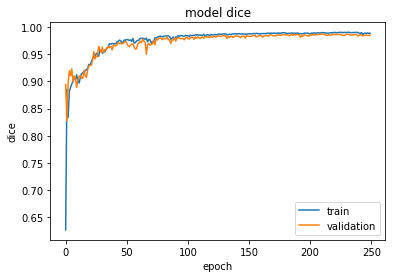

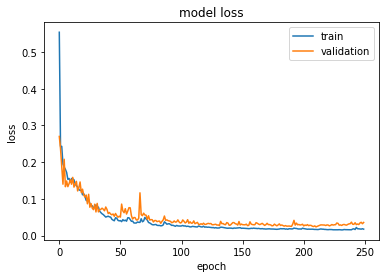

In [20]:
show_plots(hist_epi)

In [21]:
model_epi.load_weights(epi_weight_file)
def calculate_dice(images, masks_true,model_in):
    dices = []
    masks_pred = np.concatenate([model_in.predict(image[None,:,:,:]) for image in images])
    for mask_true, mask_pred in zip(masks_true, masks_pred):
        y_true = mask_true[:,:,1].astype('uint8')
        y_pred = np.round(mask_pred[:,:,1]).astype('uint8')
        dices.append(dice_coef_np(y_true.flatten(), y_pred.flatten()))
    print("Dice Average: {:.2f} Dice Stdev: {:.2f}".format(np.mean(dices), np.std(dices)))
    

print("Training Statistics(No Dropout)...")
calculate_dice(train_images, train_outer_masks,model_epi)
print("Validation Statistics(No Dropout)...")
calculate_dice(validation_images, validation_outer_masks,model_epi)

Training Statistics(No Dropout)...
Dice Average: 0.93 Dice Stdev: 0.07
Validation Statistics(No Dropout)...
Dice Average: 0.86 Dice Stdev: 0.17


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


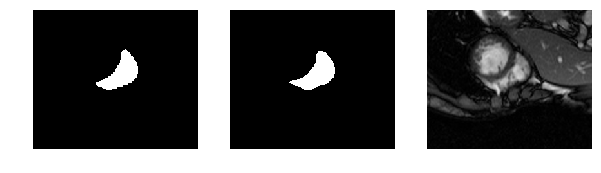

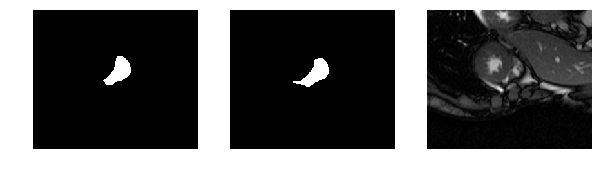

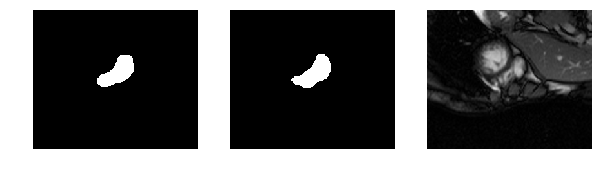

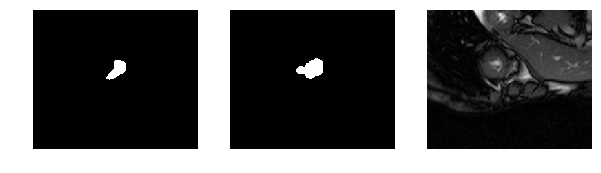

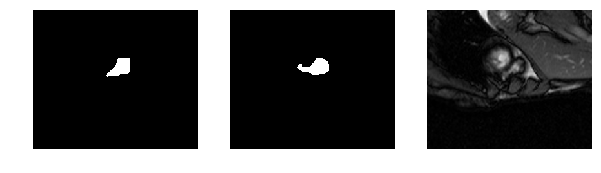

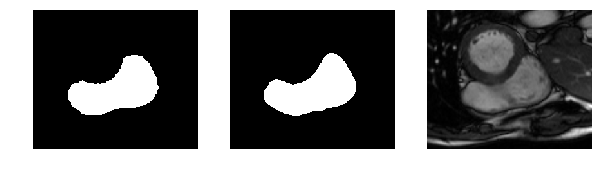

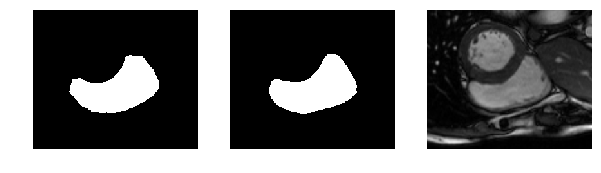

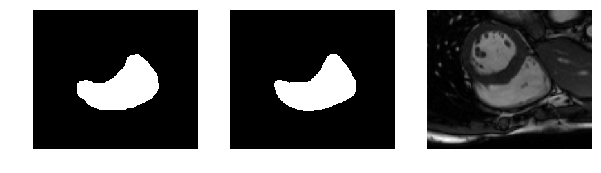

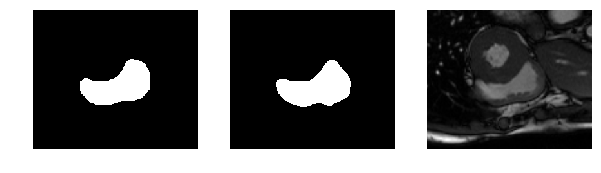

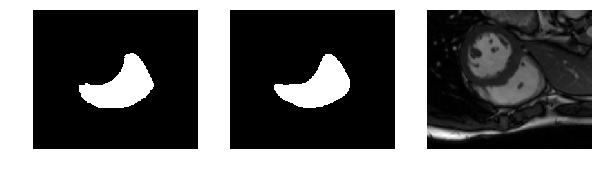

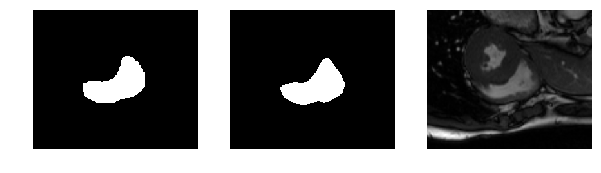

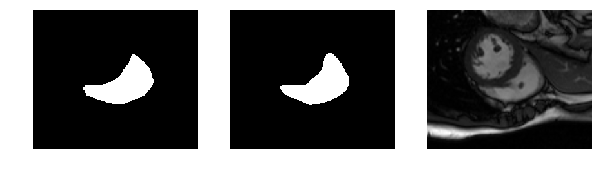

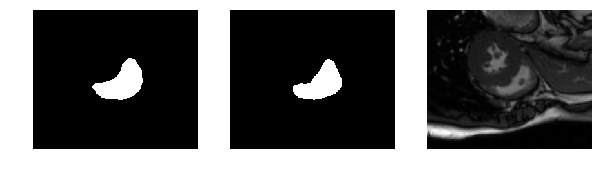

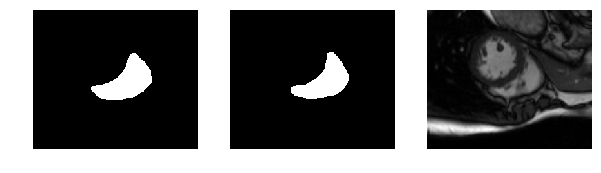

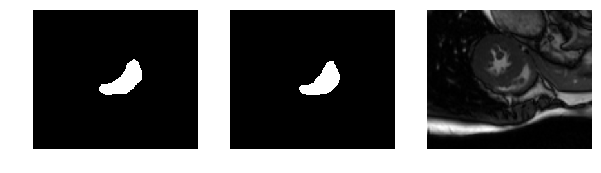

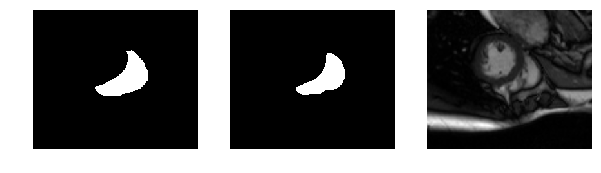

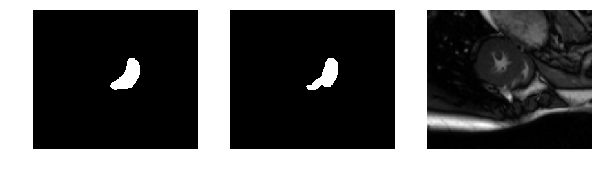

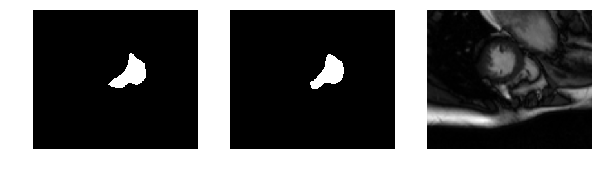

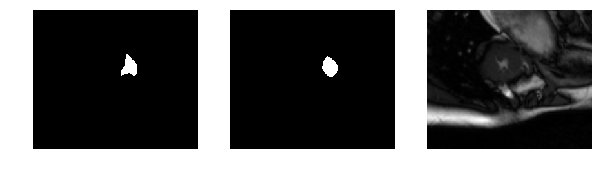

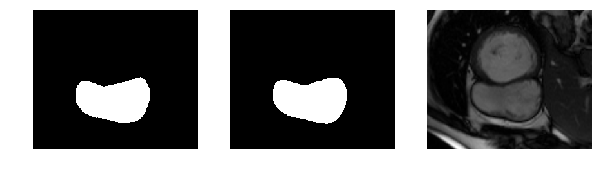

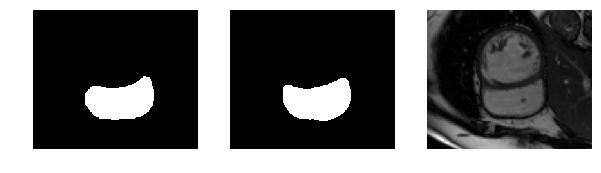

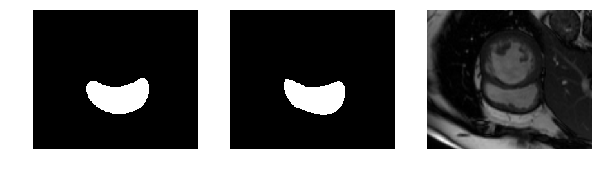

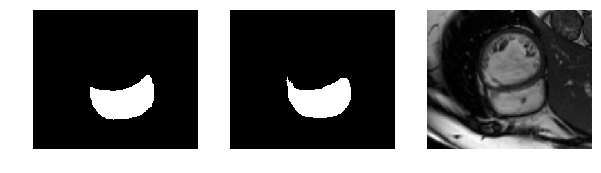

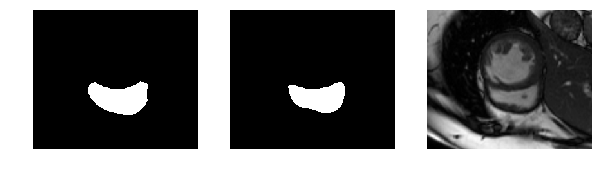

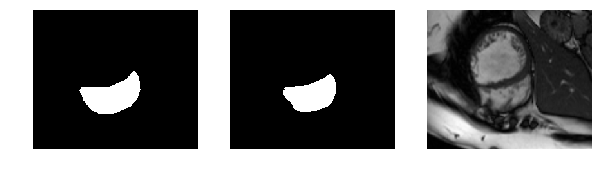

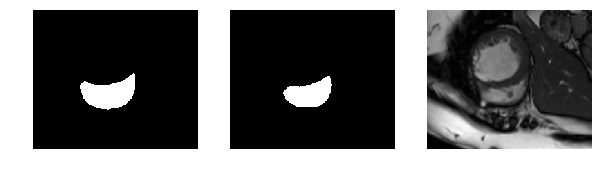

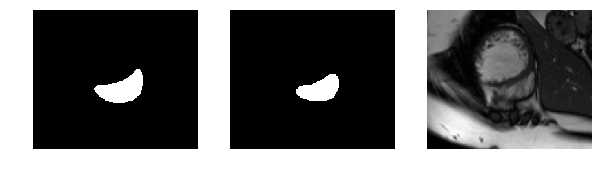

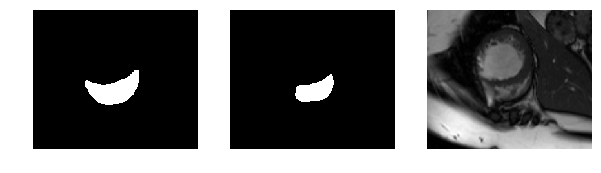

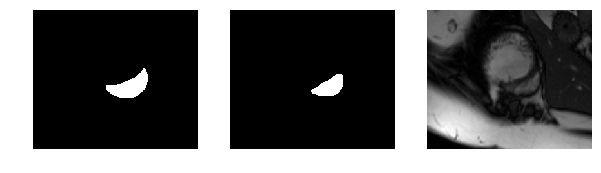

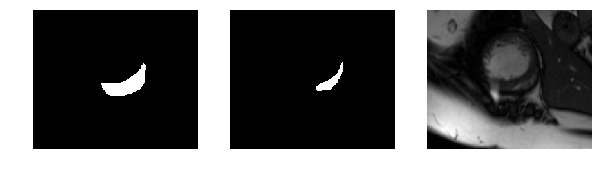

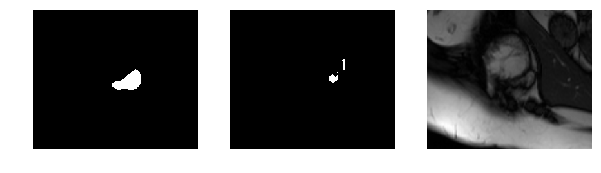

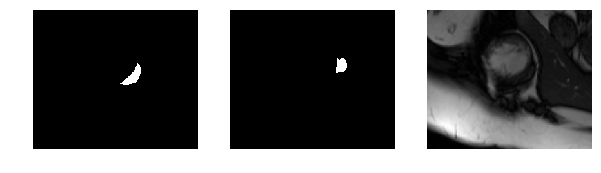

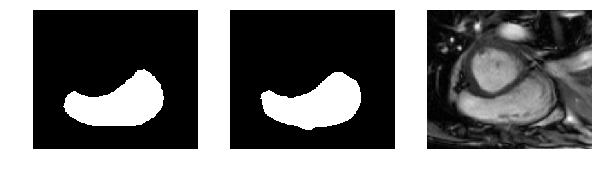

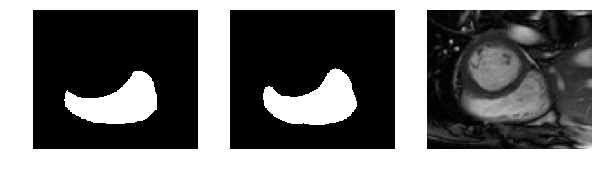

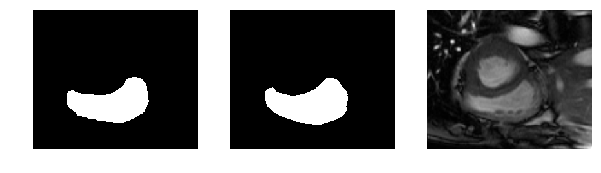

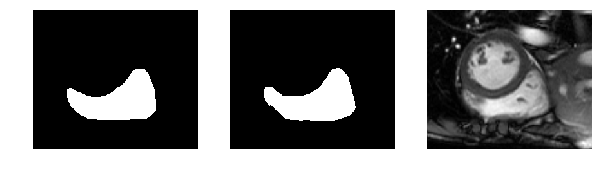

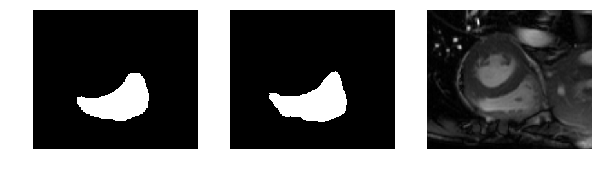

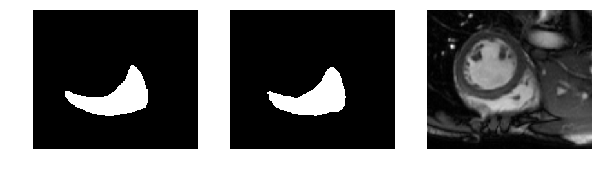

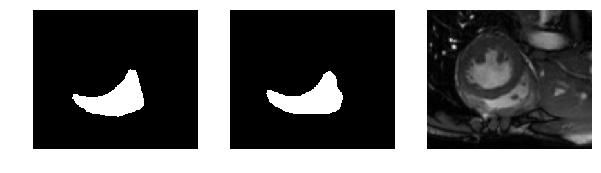

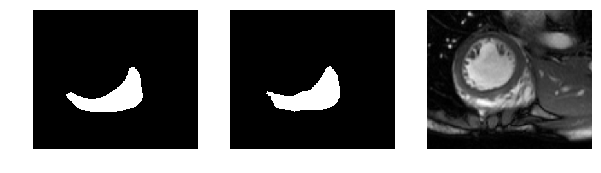

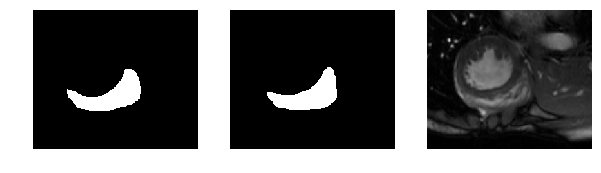

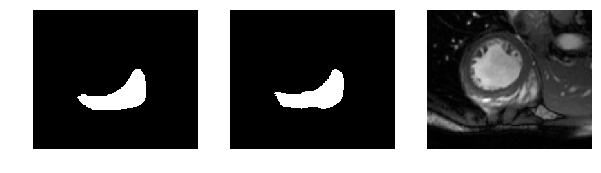

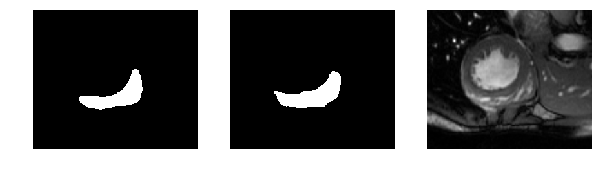

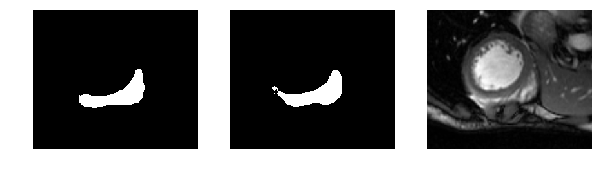

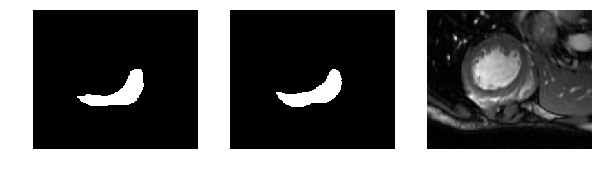

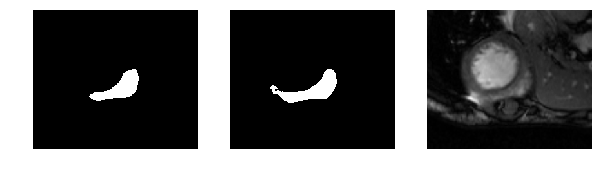

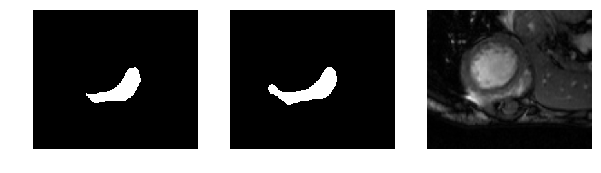

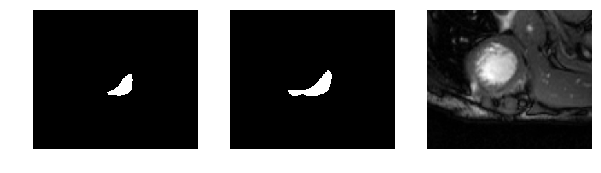

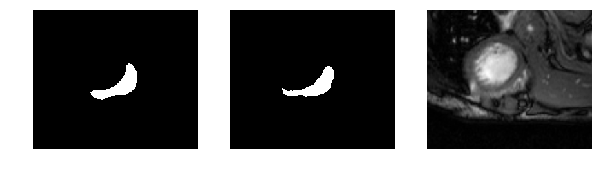

In [22]:
def show_masks_model(images, i_masks_true,model_in):
    masks_pred = np.concatenate([model_in.predict(image[None,:,:,:]) for image in images])
    counter = 0
    for (image,i_mask,mask_pred) in zip(images,i_masks_true,masks_pred):
        plt.figure(figsize=(10,5))
        plt.subplot(1, 3, 1)
        plt.axis("off")
        plt.imshow(i_mask, cmap=plt.cm.gray)
        plt.subplot(1,3,2)
        plt.axis("off")
        plt.imshow(np.round(mask_pred[:,:,1]),cmap=plt.cm.gray)
        plt.subplot(1, 3, 3)
        plt.axis("off")
        plt.imshow(image[:,:,0], cmap=plt.cm.gray)
        counter += 1
        filename = "{:2d}.png".format(counter)
        plt.savefig(os.path.join(save_imgs_dir_epi, filename))
        
show_masks_model(images[split_index:], outer_masks[split_index:],model_epi)